https://stephenholiday.com/articles/2011/gender-prediction-with-python/

In [1]:
import pandas as pd
import numpy as np
import itertools
import os
import matplotlib.pyplot as plt
from time import time, ctime
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC, LinearSVC 
from sklearn.metrics import accuracy_score, classification_report, classification, confusion_matrix
from sklearn.model_selection import train_test_split, KFold, cross_val_score, StratifiedKFold, StratifiedShuffleSplit
from sklearn.preprocessing import LabelEncoder

from helper import plot_confusion_matrix, plot_confusion_matrix2
dim=lambda *x: [i.shape for i in x]

import wordninja

In [2]:
df = pd.read_csv('./users.gender.golden.csv')
print df.shape
print df['fname.gender'].value_counts(dropna=False)
df.head()

(121335, 9)
NaN       71935
male      40389
female     9011
Name: fname.gender, dtype: int64


,user_id,username,freq,male.prob,fname.gender,male.prob2,fname.gender2,Name,pic.gender
0,5.0,billion,2.0,1.0000,male,0.920000,male,NaN,NaN
1,63.0,paddyshyam,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,64.0,ArmenSoft,1.0,1.0000,male,NaN,NaN,NaN,NaN
3,128.0,okbookman,1.0,0.9945,male,0.998834,male,NaN,NaN
4,215.0,revitupmedia,1.0,1.0000,male,NaN,NaN,215_profile.jpg,NaN


In [3]:
pre9=df[(~df['fname.gender'].isnull())][['username','fname.gender']]
print pre9.shape

pre1=df[(~df['fname.gender'].isnull())& abs(df['male.prob']-0.5)>0.4][['username','fname.gender']]
pre1.shape
pre1.head()

(49400, 2)


,username,fname.gender
0,billion,male
2,ArmenSoft,male
3,okbookman,male
4,revitupmedia,male
7,sakshiinfosys,male


In [4]:
pre1['split_words']=pre1['username'].\
apply(lambda x: ''.join([i for i in str(x) if i.isdigit()==False])).\
apply(lambda x: wordninja.split(str(x).lower()))

from genderizer.genderizer import Genderizer
import gender_guesser.detector as gender
d = gender.Detector(case_sensitive=False)

def helper(X):
    tmp = list(map(d.get_gender, X))
    tmp = [i for i in tmp if i!='unknown']
    try:
        tmp[0]
        if len(tmp)>1:
            m=0
            f=0
            for i in tmp:
                if i in ['male','mostly_male','andy']:
                    m+=1
                elif i in ['female','mostly_female']:
                    f+=1
            # change here
            if m>f:
                return 'male'
            else:
                return 'female'
        else:
            if tmp[0] in ['male','mostly_male','andy']:
                    return 'male'
            else:
                return 'female'
    except:
        return 'unknow'
    
pre1['username_split_predict'] = pre1['split_words'].apply(helper)
pre1 = pre1.drop(['split_words'],axis=1)
pre1.tail()

,username,fname.gender,username_split_predict
121328,gewens,male,male
121329,Alexa77,female,female
121330,ilmanen,female,male
121332,xmonika,female,female
121333,lidsoft,male,unknow


In [5]:
def name_count(name):
    arr = np.zeros(52+26*26+3)
    # Iterate each character
    for ind, x in enumerate(name):
        arr[ord(x)-ord('a')] += 1
        arr[ord(x)-ord('a')+26] += ind+1
    # Iterate every 2 characters
    for x in xrange(len(name)-1):
        ind = (ord(name[x])-ord('a'))*26 + (ord(name[x+1])-ord('a')) + 52
        arr[ind] += 1
        # Last character
        arr[-3] = ord(name[-1])-ord('a')
        # Second Last character
        arr[-2] = ord(name[-2])-ord('a')
    # Length of name
    arr[-1] = len(name)
    return arr

In [6]:
52+26*26+3

731

In [7]:
%%time
pre1 =pre1.reset_index(drop=True)

pre1['mock_name']= pre1['username'].apply(lambda x: ''.join([i.lower() for i in str(x) if i.isdigit()==False]))
list_list =np.array(map(name_count, pre1['mock_name']))
print list_list.shape
tmp = pd.DataFrame(data=list_list, columns=['feature_'+str(i) for i in range(731)])
print tmp.shape
tmp.head(1)

(49260, 731)
(49260, 731)
CPU times: user 959 ms, sys: 148 ms, total: 1.11 s
Wall time: 1.1 s


In [8]:
# %%time
# print cross_val_score(RandomForestClassifier(), tmp, pre0['fname.gender'], cv=10)

In [9]:
# name_count('abcdfaa')

In [10]:
# tmp = pd.DataFrame(data=name_count('abcdfaa').reshape(1,-1), columns=['feature_'+str(i) for i in range(731)])
# tmp

In [11]:
pre1.shape

(49260, 4)

In [12]:
pre1.head()

,username,fname.gender,username_split_predict,mock_name
0,billion,male,unknow,billion
1,ArmenSoft,male,male,armensoft
2,okbookman,male,female,okbookman
3,revitupmedia,male,unknow,revitupmedia
4,sakshiinfosys,male,male,sakshiinfosys


In [13]:
# pre0.head()

In [14]:
%%time
def add_features(df):
    
    df['last']= df['username'].str[-1]
    df['last_two']= df['username'].str[-2:]
    df['last_three']= df['username'].str[-3:]
    df['first']= df['username'].str[0]
    df['first2']= df['username'].str[:2]
#     df['first3']= df['username'].str[:3]
    df['nchar']= df['username'].apply(lambda x: len(str(x)))
    df['vowels.pct']=df['username'].apply(lambda x: len([i for i in str(x) if i in 'aeiouy'])/float(len(str(x))))
    df['digits.pct']=df['username'].apply(lambda x: sum([i.isdigit() for i in str(x)])/float(len(str(x))))
    df['last_is_vowel'] = df['username'].apply(lambda x: str(x)[-1] in 'aeiouy')
    df['first_is_vowel'] = df['username'].apply(lambda x: str(x)[0] in 'aeiouy')
    df['last_is_digit'] = df['username'].apply(lambda x: str(x)[-1].isdigit())
    df['first_is_digit'] = df['username'].apply(lambda x: str(x)[0].isdigit())
    df['digits.num'] = df['username'].apply(lambda x: sum([i.isdigit() for i in str(x)]))
    df['upper.pct'] = df['username'].apply(lambda x: sum([i.isupper() for i in str(x)]))
    df['first_is_upper'] = df['username'].apply(lambda x: str(x)[0].isupper())
    df.pop('mock_name')
    
    
    

    
pre0=pre1.copy()

add_features(pre0)

pre0 = pd.concat([pre0, tmp], axis=1)

print pre0.shape

(49260, 749)
CPU times: user 574 ms, sys: 54 ms, total: 628 ms
Wall time: 622 ms


In [15]:
pd.options.display.max_columns=100
pre0.head(1)

,username,fname.gender,username_split_predict,last,last_two,last_three,first,first2,nchar,vowels.pct,digits.pct,last_is_vowel,first_is_vowel,last_is_digit,first_is_digit,digits.num,upper.pct,first_is_upper,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,...,feature_681,feature_682,feature_683,feature_684,feature_685,feature_686,feature_687,feature_688,feature_689,feature_690,feature_691,feature_692,feature_693,feature_694,feature_695,feature_696,feature_697,feature_698,feature_699,feature_700,feature_701,feature_702,feature_703,feature_704,feature_705,feature_706,feature_707,feature_708,feature_709,feature_710,feature_711,feature_712,feature_713,feature_714,feature_715,feature_716,feature_717,feature_718,feature_719,feature_720,feature_721,feature_722,feature_723,feature_724,feature_725,feature_726,feature_727,feature_728,feature_729,feature_730
0,billion,male,unknow,n,on,ion,b,bi,7,0.428571,0.0,False,False,False,False,0,0,False,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,2.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0,14.0,7.0


In [16]:
pre0.head()

,username,fname.gender,username_split_predict,last,last_two,last_three,first,first2,nchar,vowels.pct,digits.pct,last_is_vowel,first_is_vowel,last_is_digit,first_is_digit,digits.num,upper.pct,first_is_upper,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,...,feature_681,feature_682,feature_683,feature_684,feature_685,feature_686,feature_687,feature_688,feature_689,feature_690,feature_691,feature_692,feature_693,feature_694,feature_695,feature_696,feature_697,feature_698,feature_699,feature_700,feature_701,feature_702,feature_703,feature_704,feature_705,feature_706,feature_707,feature_708,feature_709,feature_710,feature_711,feature_712,feature_713,feature_714,feature_715,feature_716,feature_717,feature_718,feature_719,feature_720,feature_721,feature_722,feature_723,feature_724,feature_725,feature_726,feature_727,feature_728,feature_729,feature_730
0,billion,male,unknow,n,on,ion,b,bi,7,0.428571,0.0,False,False,False,False,0,0,False,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,2.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0,14.0,7.0
1,ArmenSoft,male,male,t,ft,oft,A,Ar,9,0.222222,0.0,False,False,False,False,0,2,True,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,4.0,8.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,19.0,5.0,9.0
2,okbookman,male,female,n,an,man,o,ok,9,0.444444,0.0,False,True,False,False,0,0,False,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0,0.0,9.0
3,revitupmedia,male,unknow,a,ia,dia,r,re,12,0.500000,0.0,True,False,False,False,0,0,False,1.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,12.0,0.0,0.0,10.0,11.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,12.0
4,sakshiinfosys,male,male,s,ys,sys,s,sa,13,0.384615,0.0,False,False,False,False,0,0,False,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,2.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,9.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.0,24.0,13.0


In [17]:
# pre0.to_csv('./preprocessed.csv', index=False)

In [18]:
print pre0.iloc[:,1].value_counts()
40389.0/(40389+8871)

male      40389
female     8871
Name: fname.gender, dtype: int64


0.8199147381242388

### accuracy if set all male

In [19]:
# print pre0.columns.values
print pre0.columns.values[2:8]
pre0.head()

['username_split_predict' 'last' 'last_two' 'last_three' 'first' 'first2']


,username,fname.gender,username_split_predict,last,last_two,last_three,first,first2,nchar,vowels.pct,digits.pct,last_is_vowel,first_is_vowel,last_is_digit,first_is_digit,digits.num,upper.pct,first_is_upper,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,...,feature_681,feature_682,feature_683,feature_684,feature_685,feature_686,feature_687,feature_688,feature_689,feature_690,feature_691,feature_692,feature_693,feature_694,feature_695,feature_696,feature_697,feature_698,feature_699,feature_700,feature_701,feature_702,feature_703,feature_704,feature_705,feature_706,feature_707,feature_708,feature_709,feature_710,feature_711,feature_712,feature_713,feature_714,feature_715,feature_716,feature_717,feature_718,feature_719,feature_720,feature_721,feature_722,feature_723,feature_724,feature_725,feature_726,feature_727,feature_728,feature_729,feature_730
0,billion,male,unknow,n,on,ion,b,bi,7,0.428571,0.0,False,False,False,False,0,0,False,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,2.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0,14.0,7.0
1,ArmenSoft,male,male,t,ft,oft,A,Ar,9,0.222222,0.0,False,False,False,False,0,2,True,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,4.0,8.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,19.0,5.0,9.0
2,okbookman,male,female,n,an,man,o,ok,9,0.444444,0.0,False,True,False,False,0,0,False,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0,0.0,9.0
3,revitupmedia,male,unknow,a,ia,dia,r,re,12,0.500000,0.0,True,False,False,False,0,0,False,1.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,12.0,0.0,0.0,10.0,11.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,12.0
4,sakshiinfosys,male,male,s,ys,sys,s,sa,13,0.384615,0.0,False,False,False,False,0,0,False,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,2.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,9.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.0,24.0,13.0


In [20]:
pre0.head()

,username,fname.gender,username_split_predict,last,last_two,last_three,first,first2,nchar,vowels.pct,digits.pct,last_is_vowel,first_is_vowel,last_is_digit,first_is_digit,digits.num,upper.pct,first_is_upper,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,...,feature_681,feature_682,feature_683,feature_684,feature_685,feature_686,feature_687,feature_688,feature_689,feature_690,feature_691,feature_692,feature_693,feature_694,feature_695,feature_696,feature_697,feature_698,feature_699,feature_700,feature_701,feature_702,feature_703,feature_704,feature_705,feature_706,feature_707,feature_708,feature_709,feature_710,feature_711,feature_712,feature_713,feature_714,feature_715,feature_716,feature_717,feature_718,feature_719,feature_720,feature_721,feature_722,feature_723,feature_724,feature_725,feature_726,feature_727,feature_728,feature_729,feature_730
0,billion,male,unknow,n,on,ion,b,bi,7,0.428571,0.0,False,False,False,False,0,0,False,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,2.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0,14.0,7.0
1,ArmenSoft,male,male,t,ft,oft,A,Ar,9,0.222222,0.0,False,False,False,False,0,2,True,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,4.0,8.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,19.0,5.0,9.0
2,okbookman,male,female,n,an,man,o,ok,9,0.444444,0.0,False,True,False,False,0,0,False,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0,0.0,9.0
3,revitupmedia,male,unknow,a,ia,dia,r,re,12,0.500000,0.0,True,False,False,False,0,0,False,1.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,12.0,0.0,0.0,10.0,11.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,12.0
4,sakshiinfosys,male,male,s,ys,sys,s,sa,13,0.384615,0.0,False,False,False,False,0,0,False,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,2.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,9.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.0,24.0,13.0


In [21]:
%%time
def label_encode(df, columns):
    for col in columns:
        le = LabelEncoder()
        col_values_unique = list(df[col].unique())
        le_fitted = le.fit(col_values_unique)
 
        col_values = list(df[col].values)
        le.classes_
        col_values_transformed = le.transform(col_values)
        df[col] = col_values_transformed
 
to_be_encoded_cols = pre0.columns.values[2:9]
label_encode(pre0, to_be_encoded_cols)

# pre0 =pre0.drop(['username_split_predict'], axis=1)

CPU times: user 130 ms, sys: 0 ns, total: 130 ms
Wall time: 129 ms


In [22]:
X_train, X_test, y_train, y_test =train_test_split(pre0.iloc[:,2:], pre0.iloc[:,1], test_size=.3, stratify =pre0.iloc[:,1], 
                                                  random_state=7)
print dim(X_train, y_train, X_test, y_test )
X_train.head(1)

[(34482, 747), (34482,), (14778, 747), (14778,)]


,username_split_predict,last,last_two,last_three,first,first2,nchar,vowels.pct,digits.pct,last_is_vowel,first_is_vowel,last_is_digit,first_is_digit,digits.num,upper.pct,first_is_upper,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,...,feature_681,feature_682,feature_683,feature_684,feature_685,feature_686,feature_687,feature_688,feature_689,feature_690,feature_691,feature_692,feature_693,feature_694,feature_695,feature_696,feature_697,feature_698,feature_699,feature_700,feature_701,feature_702,feature_703,feature_704,feature_705,feature_706,feature_707,feature_708,feature_709,feature_710,feature_711,feature_712,feature_713,feature_714,feature_715,feature_716,feature_717,feature_718,feature_719,feature_720,feature_721,feature_722,feature_723,feature_724,feature_725,feature_726,feature_727,feature_728,feature_729,feature_730
1046,1,40,1678,2843,8,346,6,0.222222,0.0,True,False,False,False,0,4,True,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,7.0,0.0,5.0,0.0,9.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,21.0,9.0


In [23]:
# pre0.to_csv('preprocessed.csv',index=False)

In [24]:
# cross_val_score(RandomForestClassifier(), pre0.iloc[:,2:], pre0.iloc[:,1], cv=10)
print y_train.value_counts()

## true labels
print len(y_test)
y_test.value_counts()

male      28272
female     6210
Name: fname.gender, dtype: int64
14778


male      12117
female     2661
Name: fname.gender, dtype: int64

In [25]:
%%time
fr=RandomForestClassifier()
fr.fit(X_train, y_train)
## predict labels
fr_p = fr.predict(X_test)
pd.Series(fr_p).value_counts()

CPU times: user 3.25 s, sys: 324 ms, total: 3.57 s
Wall time: 3.57 s


0.819935038571
0.817769657599
Confusion matrix, without normalization
[[  430  2231]
 [  462 11655]]


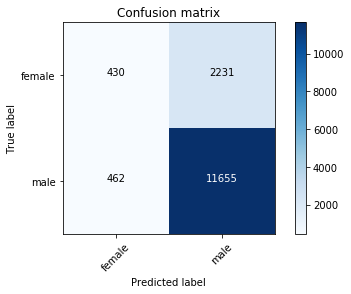

In [26]:
print 12117/14778.0
print accuracy_score(y_test, fr_p)
plot_confusion_matrix(confusion_matrix(y_test,fr_p), ['female','male'])

In [27]:
%%time
fr=RandomForestClassifier(n_estimators=150, min_samples_split=5, n_jobs=24)
fr.fit(X_train, y_train)
## predict labels
fr_p = fr.predict(X_test)
pd.Series(fr_p).value_counts()

CPU times: user 51.2 s, sys: 885 ms, total: 52 s
Wall time: 4.17 s


0.819935038571
0.830761943429
Confusion matrix, without normalization
[[  180  2481]
 [   20 12097]]


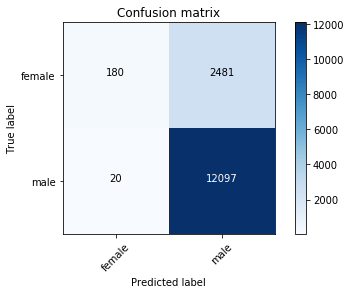

In [28]:
print 12117/14778.0
print accuracy_score(y_test, fr_p)
plot_confusion_matrix(confusion_matrix(y_test,fr_p), ['female','male'])

In [29]:
%%time
fr=RandomForestClassifier(n_estimators=640, min_samples_split=4, n_jobs=24)
fr.fit(X_train, y_train)
## predict labels
fr_p = fr.predict(X_test)
pd.Series(fr_p).value_counts()

CPU times: user 3min 35s, sys: 1.15 s, total: 3min 36s
Wall time: 12.3 s


0.819935038571
0.831438624983
Confusion matrix, without normalization
[[  186  2475]
 [   16 12101]]


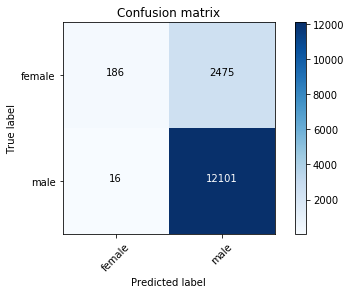

In [30]:
print 12117/14778.0
print accuracy_score(y_test, fr_p)
plot_confusion_matrix(confusion_matrix(y_test,fr_p), ['female','male'])

In [31]:
def plotting(model, df, num):
    forest = model
    importances = forest.feature_importances_
    std = np.std([tree.feature_importances_ for tree in forest.estimators_],
                 axis=0)
    indices = np.argsort(importances)[::-1]



    # Plot the feature importances of the forest
    plt.figure(figsize=(16,8))
    plt.title("Feature importances")
    plt.barh(range(num), importances[indices][:num],
           color="g", xerr=std[indices][:num], 
            align="center", alpha=.7)

    plt.yticks(range(num), list(df.columns[indices][:num],))
    plt.ylim([-1, num])

    plt.gca().invert_yaxis()

    plt.show()

    # Print the feature ranking
    print("Feature ranking:")
    for f in range(df.shape[1]):
        print("{}. feature {} ({:.2f} %)" .format (f + 1, df.columns[indices[f]], 100*importances[indices[f]]))

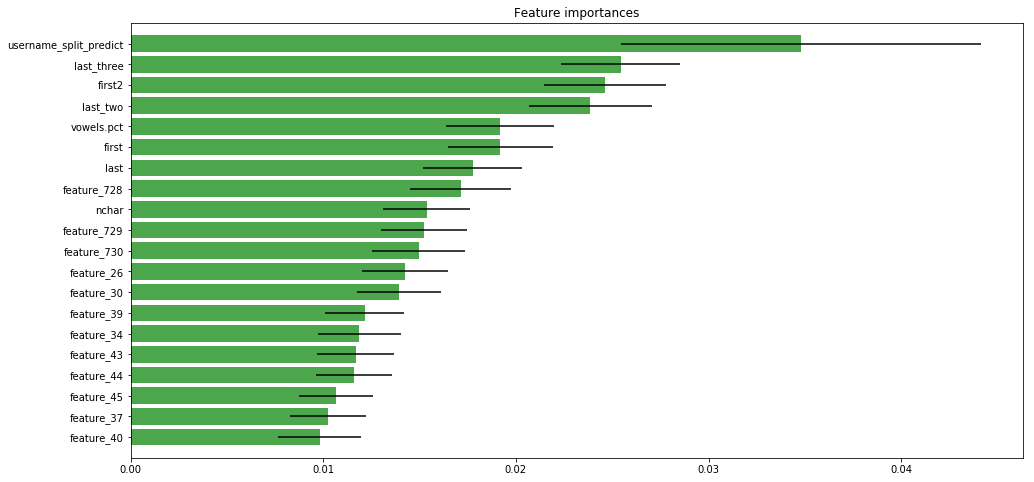

Feature ranking:
1. feature username_split_predict (3.48 %)
2. feature last_three (2.54 %)
3. feature first2 (2.46 %)
4. feature last_two (2.39 %)
5. feature vowels.pct (1.92 %)
6. feature first (1.92 %)
7. feature last (1.78 %)
8. feature feature_728 (1.72 %)
9. feature nchar (1.54 %)
10. feature feature_729 (1.52 %)
11. feature feature_730 (1.50 %)
12. feature feature_26 (1.43 %)
13. feature feature_30 (1.39 %)
14. feature feature_39 (1.21 %)
15. feature feature_34 (1.19 %)
16. feature feature_43 (1.17 %)
17. feature feature_44 (1.16 %)
18. feature feature_45 (1.07 %)
19. feature feature_37 (1.02 %)
20. feature feature_40 (0.98 %)
21. feature digits.pct (0.95 %)
22. feature feature_38 (0.91 %)
23. feature feature_28 (0.91 %)
24. feature feature_29 (0.78 %)
25. feature feature_33 (0.76 %)
26. feature feature_0 (0.75 %)
27. feature feature_4 (0.70 %)
28. feature feature_27 (0.69 %)
29. feature feature_46 (0.69 %)
30. feature feature_32 (0.68 %)
31. feature feature_36 (0.67 %)
32. featu

In [32]:
plotting(fr, X_train, 20)

In [33]:
# RandomForestClassifier?

In [34]:
%%time
fr=RandomForestClassifier(n_estimators=200
                          , min_samples_split=6, n_jobs=24, criterion='entropy')
fr.fit(X_train, y_train)
## predict labels
fr_p = fr.predict(X_test)
pd.Series(fr_p).value_counts()

CPU times: user 1min 3s, sys: 366 ms, total: 1min 3s
Wall time: 4.96 s


0.819935038571
0.831303288672
Confusion matrix, without normalization
[[  182  2479]
 [   14 12103]]


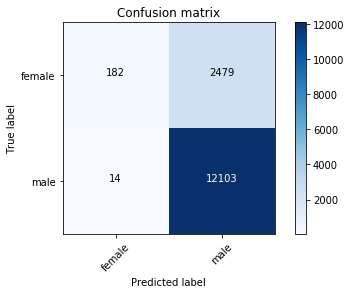

In [35]:
print 12117/14778.0
print accuracy_score(y_test, fr_p)
plot_confusion_matrix(confusion_matrix(y_test,fr_p), ['female','male'])

0.265665177967
Confusion matrix, without normalization
[[ 2326   335]
 [10517  1600]]


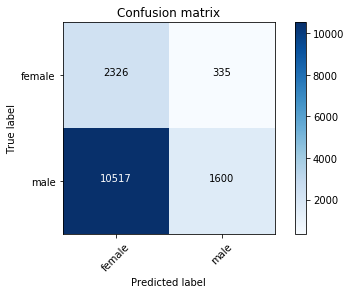

CPU times: user 8.55 s, sys: 2.52 s, total: 11.1 s
Wall time: 8.34 s


In [36]:
%%time
lsvm = LinearSVC()
lsvm.fit(X_train, y_train)
lsvm_pr=lsvm.predict(X_test)
pd.Series(lsvm_pr).value_counts()
print accuracy_score(y_test, lsvm_pr)
plot_confusion_matrix(confusion_matrix(y_test,lsvm_pr), ['female','male'])

### try xgboost

https://github.com/dmlc/xgboost/blob/master/doc/parameter.md

In [37]:
import xgboost as xgb

/home/shj16110/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [38]:
d_train = xgb.DMatrix(X_train, label=y_train.map({'male':1, 'female':0}))
d_test = xgb.DMatrix(X_test, label=y_test.map({'male':1, 'female':0}))

In [39]:
d_train.get_label()

array([ 0.,  1.,  1., ...,  1.,  1.,  1.], dtype=float32)

In [40]:
RANDOM_STATE = 2017
params = {
    'min_child_weight': 0.7,
#     'eta': 0.1,
    'colsample_bytree': 0.7,
    'max_depth': 24,
    'subsample': 0.7,
    'alpha': 0.2,
    'lambda':0.8,
    'gamma': 0.2,
    'silent': 0,
    'learning_rate':0.05,
    'verbose_eval': True,
    'seed': RANDOM_STATE,
    'objective':"binary:logistic",
#     'eval_metric':'error'
#     'num_class':1
    'n_jobs':12
    
}
watchlist = [(d_train, 'train'), (d_test, 'test')]

def xg_eval(pred, dtrain):
    y = dtrain.get_label()
    tmp = map(lambda x: 0 if x<0.5 else 1, pred)
    return 'acc', accuracy_score(y, tmp)

In [41]:
def female_eval(pred, dtrain):
    y = dtrain.get_label()
    tmp = map(lambda x: 0 if x<0.5 else 1, pred)
    cof = confusion_matrix(y, tmp)
    g_f_c = cof[0][0]
    b_f_c = cof[1][0]
    r_f_c = cof[0][1]
    target = (g_f_c - 1.1*b_f_c)/float(r_f_c)
    return 'female_acc',target
    

In [42]:
start=time()

clf = xgb.train(params, d_train, 10000, watchlist, early_stopping_rounds=100, 
                verbose_eval=20, feval=xg_eval, maximize=True)
                


'!!! used %.2f s'%(time()-start)

[0]	train-acc:0.853895	test-acc:0.796048
Multiple eval metrics have been passed: 'test-acc' will be used for early stopping.

Will train until test-acc hasn't improved in 100 rounds.
[20]	train-acc:0.866945	test-acc:0.829273
[40]	train-acc:0.881445	test-acc:0.829882
[60]	train-acc:0.900789	test-acc:0.830694
[80]	train-acc:0.922974	test-acc:0.832521
[100]	train-acc:0.943884	test-acc:0.833333
[120]	train-acc:0.958181	test-acc:0.834416
[140]	train-acc:0.970477	test-acc:0.834957
[160]	train-acc:0.980338	test-acc:0.835296
[180]	train-acc:0.986979	test-acc:0.835634
[200]	train-acc:0.991416	test-acc:0.835228
[220]	train-acc:0.995012	test-acc:0.83489
[240]	train-acc:0.997042	test-acc:0.83489
[260]	train-acc:0.998173	test-acc:0.834281
[280]	train-acc:0.999101	test-acc:0.833672
Stopping. Best iteration:
[186]	train-acc:0.988632	test-acc:0.83604



'!!! used 68.46 s'

accuracy 0.83367167411
statistic
male      14179
female      599
dtype: int64
Confusion matrix, without normalization
[[  401  2260]
 [  198 11919]]


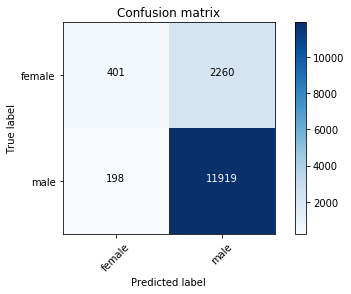

In [43]:
# pd.Series(clf.predict(d_test)).describe()
print 'accuracy',accuracy_score(d_test.get_label(), clf.predict(d_test)>.5)
print 'statistic'
print pd.Series(clf.predict(d_test)>.5).map({1:'male',0:'female'}).value_counts()
plot_confusion_matrix(confusion_matrix(d_test.get_label(),clf.predict(d_test)>.5), ['female','male'])

#### on accuracy 

### tune

In [44]:
RANDOM_STATE = 2017
params = {
    'min_child_weight': 0.7,
#     'eta': 0.1,
    'colsample_bytree': 0.7,
    'max_depth': 24,
    'subsample': 0.7,
    'alpha': 0.2,
    'lambda':0.8,
    'gamma': 0.2,
    'silent': 0,
    'learning_rate':0.05,
    'verbose_eval': True,
    'seed': RANDOM_STATE,
    'objective':"binary:logistic",
#     'eval_metric':'error'
#     'num_class':1
    'n_jobs':12
    
}
watchlist = [(d_train, 'train'), (d_test, 'test')]

def xg_eval(pred, dtrain):
    y = dtrain.get_label()
    tmp = map(lambda x: 0 if x<0.5 else 1, pred)
    return 'acc', accuracy_score(y, tmp)

In [45]:
y_train.value_counts()

male      28272
female     6210
Name: fname.gender, dtype: int64

In [46]:
6210.0/28272

0.21965195246179967

In [47]:
RANDOM_STATE = 2017

params = {
    'min_child_weight': 0.8,
#     'eta': 0.1,
    'colsample_bytree': 0.8,
    'max_depth': 28,
    'subsample': 0.8,
    'alpha': 2,
    'lambda':3,
    'gamma': 0.1,
    'silent': 0,
    'learning_rate':0.01,
    'verbose_eval': True,
    'seed': RANDOM_STATE,
    'objective':"binary:logistic",
#     'eval_metric':'error'
#     'num_class':1
    'n_jobs':12,
        'max_delta_step ':7,
        'colsample_bylevel ':0.9 ,    
}
watchlist = [(d_train, 'train'), (d_test, 'test')]

def xg_eval(pred, dtrain):
    y = dtrain.get_label()
    tmp = map(lambda x: 0 if x<0.5 else 1, pred)
    return 'acc', accuracy_score(y, tmp)

In [48]:
start=time()

clf = xgb.train(params, d_train, 10000, watchlist, early_stopping_rounds=200, 
                verbose_eval=20, feval=xg_eval, maximize=True)
                


'!!! used %.2f s'%(time()-start)

[0]	train-acc:0.83864	test-acc:0.820747
Multiple eval metrics have been passed: 'test-acc' will be used for early stopping.

Will train until test-acc hasn't improved in 200 rounds.
[20]	train-acc:0.846036	test-acc:0.827379
[40]	train-acc:0.847689	test-acc:0.826431
[60]	train-acc:0.847051	test-acc:0.826634
[80]	train-acc:0.848675	test-acc:0.826905
[100]	train-acc:0.850038	test-acc:0.827649
[120]	train-acc:0.851662	test-acc:0.828191
[140]	train-acc:0.852735	test-acc:0.828935
[160]	train-acc:0.854533	test-acc:0.829206
[180]	train-acc:0.856331	test-acc:0.829003
[200]	train-acc:0.857636	test-acc:0.829747
[220]	train-acc:0.859115	test-acc:0.82995
[240]	train-acc:0.86042	test-acc:0.829544
[260]	train-acc:0.86187	test-acc:0.829679
[280]	train-acc:0.863552	test-acc:0.829882
[300]	train-acc:0.864944	test-acc:0.830288
[320]	train-acc:0.866655	test-acc:0.830424
[340]	train-acc:0.869236	test-acc:0.830762
[360]	train-acc:0.87115	test-acc:0.830559
[380]	train-acc:0.873441	test-acc:0.830897
[400]	tra

'!!! used 336.06 s'

accuracy 0.834213019353
statistic
male      14205
female      573
dtype: int64
Confusion matrix, without normalization
[[  392  2269]
 [  181 11936]]


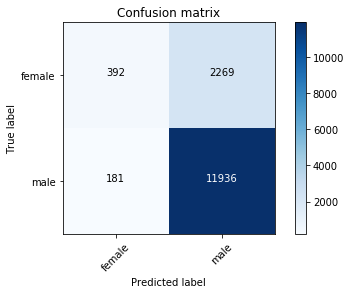

In [49]:
# pd.Series(clf.predict(d_test)).describe()
print 'accuracy',accuracy_score(d_test.get_label(), clf.predict(d_test)>.5)
print 'statistic'
print pd.Series(clf.predict(d_test)>.5).map({1:'male',0:'female'}).value_counts()
plot_confusion_matrix(confusion_matrix(d_test.get_label(),clf.predict(d_test)>.5), ['female','male'])

In [50]:
f_ip = pd.DataFrame(clf.get_fscore().items(), columns=['feature','importance']).sort_values('importance', ascending=False)
f_ip.head(10)

,feature,importance
486,last_three,59599
279,first2,48705
141,last_two,47209
361,vowels.pct,38012
422,last,29260
255,first,26157
516,feature_728,21845
425,nchar,20901
527,feature_30,20868
515,feature_729,20750


In [51]:
# pd.DataFrame.plot?

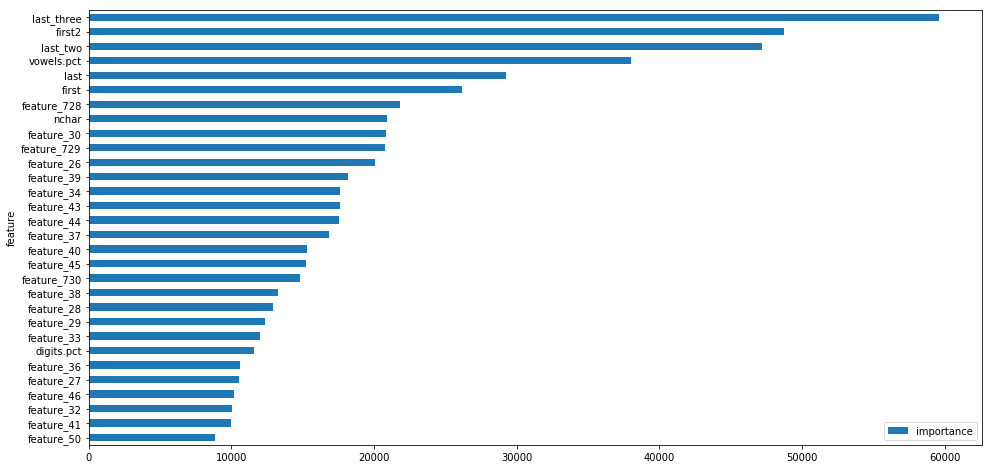

In [52]:
f_ip.head(30).iloc[::-1].set_index('feature').plot(kind='barh', figsize=(16,8))
plt.show()

In [53]:
pre0 = pre1.copy()
pre0.head(3)

,username,fname.gender,username_split_predict,mock_name
0,billion,male,unknow,billion
1,ArmenSoft,male,male,armensoft
2,okbookman,male,female,okbookman


### other sklearn models

In [54]:
# %%time
# lsvm = LinearSVC()
# lsvm.fit(X_train, y_train)
# lsvm_pr=lsvm.predict(X_test)
# pd.Series(lsvm_pr).value_counts()
# print accuracy_score(y_test, lsvm_pr)
# plot_confusion_matrix(confusion_matrix(y_test,lsvm_pr), ['female','male'])

In [55]:
# cross_val_score(SVC(), pre0.iloc[:,2:], pre0.iloc[:,1], cv=10)

In [56]:
# svm = SVC()
# svm

In [57]:
# %%time
# # svm.fit(X_train, y_train)

In [58]:
# from sklearn.neural_network import MLPClassifier

In [59]:
# neur = MLPClassifier(verbose=True, learning_rate='adaptive', hidden_layer_sizes=(200,20,1))
# neur

https://wiki.hpc.uconn.edu/index.php/GPU_Guide

In [60]:
# %%time
# neur.fit(X_train, y_train)
# neur_prd = neur.predict(X_test)

In [61]:
# pd.Series(neur_prd).value_counts()

In [62]:
# accuracy_score(y_test,neur_prd)

In [63]:
# plot_confusion_matrix(confusion_matrix(y_test,neur_prd), ['female','male'])

In [64]:
# %%time
# pred = svm.predict(X_test)
# pred.shape

In [65]:
# pd.Series(pred).value_counts()

In [66]:
# accuracy_score(y_test, pred)

In [67]:
# confusion_matrix(y_test,pred)

In [68]:
# plot_confusion_matrix(confusion_matrix(y_test,pred), ['female','male'])


In [69]:
# from sklearn.naive_bayes import BernoulliNB

In [70]:
# nb = BernoulliNB()
# nb

In [71]:
# %%time
# nb.fit(X_train, y_train)
# nb_pd=nb.predict(X_test)
# print pd.Series(nb_pd).value_counts()